In [ ]:
#Hierarchical Data Format version hdf5
pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import h5py
import random
import warnings
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')

In [ ]:

#Open the H5 file contatining MNIST data
file_path='/content/drive/MyDrive/ANN ASSIGNMENT/MNIST_Subset.h5'
with h5py.File(file_path, 'r') as data_file:
    print("The keys are: ", data_file.keys())
    print('-'*20)

    a_group_key = list(data_file.keys())[0]


    # Getting the data
    data = list(data_file[a_group_key])
    print(data[5])
    print('-'*20)

    X = data_file['X'][:]
    Y = data_file['Y'][:]

    print("The shape of independent data :", X.shape)
    print("The shape of dependent data :", Y.shape)

    print('-'*20)

    print(X[0])
    print('-'*20)
    print(Y[0])
    print('-'*20)
    flatten_X = X.reshape(14251,28*28)
    print(flatten_X[5])
    print('-'*20)
    print(np.unique(Y))
    print('-'*20)

    encoded_Y = np.zeros((Y.size, 10), dtype=int)
    encoded_Y[np.arange(Y.size),Y] = 1

    print(encoded_Y[0])



The keys are:  <KeysViewHDF5 ['X', 'Y']>
--------------------
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  45 103 254 254
  255 184  73   0   0   0   0   0   0   0]
 [

In [ ]:
# the sigmoid activation function
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [ ]:
# the softmax activation function
def softmax(z):
  return np.exp(z)/np.sum(np.exp(z))

In [ ]:
# the loss function for our model
def cross_entropy_loss(Y_train, output):
  #print(Y_train.shape)
  #print(output.shape)
  cost=-np.sum(Y_train*np.log(output))
  return cost

In [ ]:
def sigmoid_derivative(z):
  return z*(1-z)

In [ ]:
def relu(z):
  return np.maximum(0,z)

In [ ]:
def relu_derivative(z):
  z[z<=0] = 0
  z[z>0] = 1
  return z

In [ ]:
def accuracy_calculate(encoded_Y,predicted_output):
  count=0
  for i in range(0,len(predicted_output)):
       predict_index=np.argmax(predicted_output[i], axis=0)
       actual_index=np.argmax(encoded_Y[i], axis=0)
       if(predict_index==actual_index):
         count+=1
  return count/len(predicted_output)

In [ ]:
def train_valid_split(X, Y, val_size=0.2):
    np.random.seed(4)

    index = np.random.permutation(X.shape[0])

    # Determine the split index
    split_idx = int(X.shape[0] * (1 - val_size))

    # Split the data into training and validation sets
    X_train, X_valid = X[index[:split_idx]], X[index[split_idx:]]
    Y_train, Y_valid = Y[index[:split_idx]], Y[index[split_idx:]]

    return X_train, Y_train, X_valid, Y_valid

# PART A

In [ ]:
def front_propagation(row_data,weights,bias,layers):
  #taking the row data
  activations={}
  activations[0]=row_data
  for i in range(1,layers):
      z=np.dot(weights[i],activations[i-1])
      z=z.reshape(z.shape[0],1)
      z=z + bias[i]
      activations[i]=sigmoid(z)


  z=np.dot(weights[layers],activations[layers-1]) + bias[layers]
  activations[layers]=softmax(z)
  return activations


In [ ]:
def back_propagation(actual_output,weights,activations,layers):
    delta={}
    delta_weights={}
    delta_bias={}
    #output layer
    actual_output=actual_output.reshape(actual_output.shape[0],1)
    delta[layers]=activations[layers]-actual_output
    delta_bias[layers]=delta[layers]
    delta_weights[layers]=np.dot(delta[layers],activations[layers-1].T)

    #hidden layers
    for i in range(layers-1,0,-1):
      delta[i]=weights[i+1].T.dot(delta[i+1])*sigmoid_derivative(activations[i])
      delta_bias[i]=delta[i]
      activations[i-1]=activations[i-1].reshape(activations[i-1].shape[0],1)
      delta_weights[i]=np.dot(delta[i],activations[i-1].T)
    return delta_weights,delta_bias

In [ ]:
def architecture_ANN( X_train, Y_train,layers,nodes,learning_rate=0.001):
  #to get same result every time
  random.seed(4)

  weights={}
  bias={}
  predicted_output=[]
  loss=[]

  for i in range(1, layers+1):
    activations={}
    weights[i] = np.random.randn(nodes[i], nodes[i-1])*0.1
    bias[i] = np.random.randn(nodes[i], 1)

  #training the model
  for i in range (0,X_train.shape[0]):
    #FORWARD PROPAGATION
    activations={}
    activations[0]=X_train[i]
    actual_output=Y_train[i]

    activations=front_propagation(activations[0],weights,bias,layers)
    predicted_output.append(activations[layers])

    #loss
    loss.append(cross_entropy_loss(actual_output, activations[layers]))

    #BACKWARD PROPAGATION
    delta={}
    delta_weights={}
    delta_bias={}

    delta_weights,delta_bias=back_propagation(actual_output,weights,activations,layers)

    #updating parameters
    for i in range(1,layers+1):
      weights[i]=weights[i]-learning_rate*delta_weights[i]
      bias[i]=bias[i]-learning_rate*delta_bias[i]

  return weights,bias,predicted_output,loss

In [ ]:
weights1,bias1,predicted_output1,loss1= architecture_ANN(flatten_X,encoded_Y,2,[784,100,10])

In [ ]:
import pickle
# weights is a Python array
pickle.dump([weights1,bias1] , open( 'architecture1_sigmoid.pkl' , 'wb' ) )

In [ ]:
len(predicted_output1)

14251

In [ ]:
predicted_output1[0]

array([[0.0503008 ],
       [0.03272496],
       [0.01209336],
       [0.55673427],
       [0.01012506],
       [0.06497954],
       [0.07985888],
       [0.03316707],
       [0.11469491],
       [0.04532116]])

In [ ]:
predicted_output1[234]

array([[0.09242956],
       [0.04306967],
       [0.02030683],
       [0.05270552],
       [0.00292523],
       [0.12136939],
       [0.03931509],
       [0.23325688],
       [0.01887048],
       [0.37575135]])

In [ ]:
out=np.argmax(predicted_output1[234], axis=0)
print(out)

[9]


In [ ]:
encoded_Y[234]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
accuracy_calculate(encoded_Y,predicted_output1)

0.9127780506631114

In [ ]:
weights2,bias2,predicted_output2,loss2= architecture_ANN(flatten_X,encoded_Y,4,[784,100,50,50,10])

In [ ]:
accuracy_calculate(encoded_Y,predicted_output2)

0.5136481650410497

In [ ]:
import pickle
# weights is a Python array
pickle.dump([ weights2,bias2] , open( 'architecture2_sigmoid.pkl' , 'wb' ) )

#PART B

In [ ]:
def predict(X,weights,bias,layers):
  output=[]
  for i in range (0,X.shape[0]):
    #FORWARD PROPAGATION
    activations={}
    activations[0]=X[i]
    activations=front_propagation(activations[0],weights,bias,layers)
    output.append(activations[layers])
  return output

In [ ]:
#Split MNIST data into 80% training and 20% validation
X_train, Y_train, X_valid, Y_valid = train_valid_split(flatten_X, encoded_Y, val_size=0.2)

In [ ]:
X_train.shape

(11400, 784)

In [ ]:
Y_train.shape

(11400, 10)

In [ ]:
X_valid.shape

(2851, 784)

In [ ]:
Y_valid.shape

(2851, 10)

In [ ]:
weights1,bias1,predicted_output1,loss1= architecture_ANN(X_train,Y_train,2,[784,100,10])

In [ ]:
train_predicted_output1=predict(X_train,weights1,bias1,2)
test_predicted_output1=predict(X_valid,weights1,bias1,2)

training_accuracy=accuracy_calculate(Y_train,train_predicted_output1)
testing_accuracy=accuracy_calculate(Y_valid,test_predicted_output1)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)


Training dataset accuracy score:  0.9358771929824561
Testing dataset accuracy score:  0.9407225534900036


In [ ]:
weights2,bias2,predicted_output2,loss2= architecture_ANN(X_train,Y_train,4,[784,100,50,50,10])

In [ ]:
train_predicted_output2=predict(X_train,weights2,bias2,4)
test_predicted_output2=predict(X_valid,weights2,bias2,4)

training_accuracy=accuracy_calculate(Y_train,train_predicted_output2)
testing_accuracy=accuracy_calculate(Y_valid,test_predicted_output2)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)

Training dataset accuracy score:  0.5267543859649123
Testing dataset accuracy score:  0.5198176078568923


In [ ]:
loss1[20:30]

[25.11492284325629,
 26.16098022046136,
 29.634179403452563,
 24.999208225062926,
 25.222913078085682,
 26.598502429626706,
 24.582198058377905,
 25.502982629103037,
 25.28943630768532,
 25.64613797480135]

## VISUALIZATIONS

In [ ]:
def avg_loss(loss):
  batch_loss=[]
  batch_loss = [np.mean(loss[i:i+10]) for i in range(0, len(loss), 10)]
  return batch_loss

In [ ]:
def plot(batch_loss):
  plt.figure(figsize=(10,6))
  plt.plot(np.arange(1,len(batch_loss)+1),batch_loss)
  plt.title('Average loss per 100 data instances')
  plt.xlabel('Epochs')
  plt.ylabel('Average loss')
  plt.show()



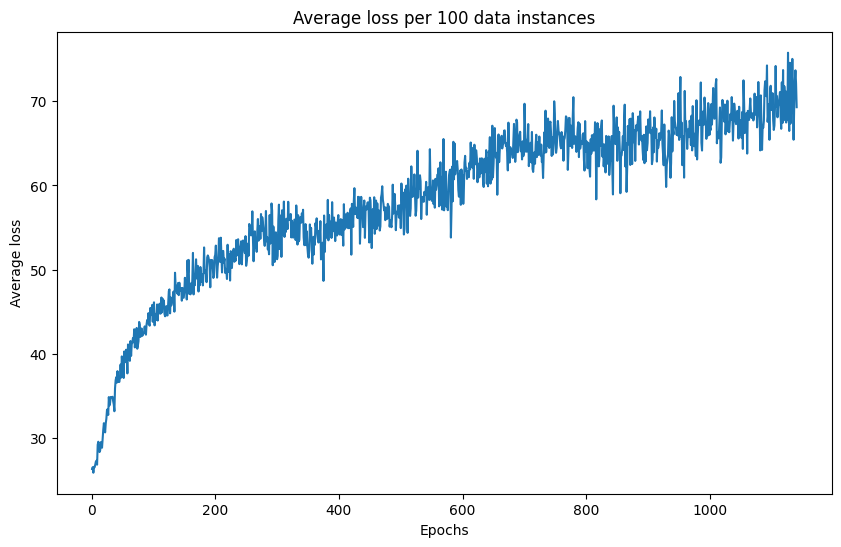

In [ ]:
batch_loss1=avg_loss(loss1)
plot(batch_loss1)

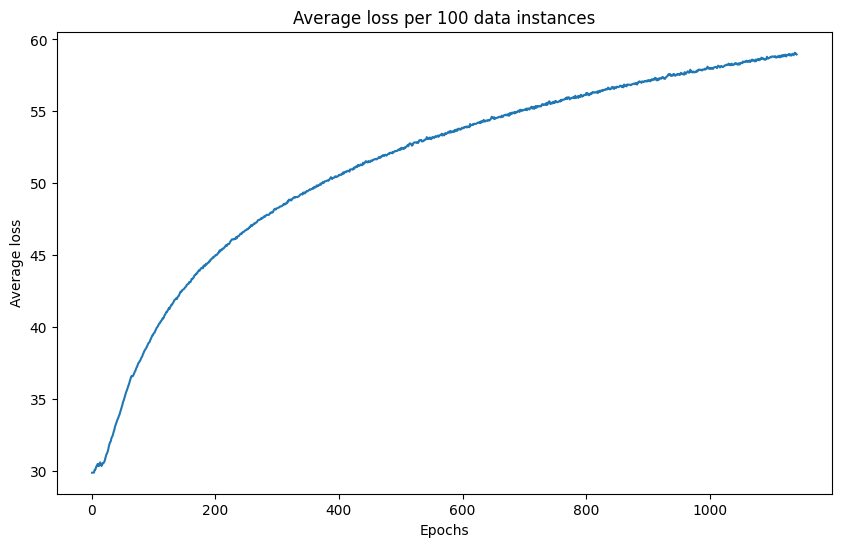

In [ ]:
batch_loss2=avg_loss(loss2)
plot(batch_loss2)

#PART C

##PART C(A)

In [ ]:
def front_propagation_RELU(row_data,weights,bias,layers):
  #taking the row data
  activations={}
  activations[0]=row_data
  for i in range(1,layers):
      z=np.dot(weights[i],activations[i-1])
      z=z.reshape(z.shape[0],1)
      z=z + bias[i]
      activations[i]=relu(z)


  z=np.dot(weights[layers],activations[layers-1]) + bias[layers]
  activations[layers]=softmax(z)
  return activations


In [ ]:
def back_propagation_RELU(actual_output,weights,activations,layers):
    delta={}
    delta_weights={}
    delta_bias={}
    #output layer
    actual_output=actual_output.reshape(actual_output.shape[0],1)
    delta[layers]=activations[layers]-actual_output
    delta_bias[layers]=delta[layers]
    delta_weights[layers]=np.dot(delta[layers],activations[layers-1].T)

    #hidden layers
    for i in range(layers-1,0,-1):
      delta[i]=weights[i+1].T.dot(delta[i+1])*relu_derivative(activations[i])
      delta_bias[i]=delta[i]
      activations[i-1]=activations[i-1].reshape(activations[i-1].shape[0],1)
      delta_weights[i]=np.dot(delta[i],activations[i-1].T)
    return delta_weights,delta_bias

In [ ]:
def architecture_ANN_RELU( X_train, Y_train,layers,nodes,learning_rate=0.001):
  #to get same result every time
  random.seed(4)

  weights={}
  bias={}
  predicted_output=[]
  loss=[]
  validation_loss=[]

  for i in range(1, layers+1):
    activations={}
    weights[i] = np.random.randn(nodes[i], nodes[i-1])*0.1
    bias[i] = np.random.randn(nodes[i], 1)

  #training the model
  for i in range (0,X_train.shape[0]):
    #FORWARD PROPAGATION
    activations={}
    activations[0]=X_train[i]
    actual_output=Y_train[i]

    activations=front_propagation_RELU(activations[0],weights,bias,layers)
    predicted_output.append(activations[layers])

    #loss
    loss.append(cross_entropy_loss(actual_output, activations[layers]))

    #BACKWARD PROPAGATION
    delta={}
    delta_weights={}
    delta_bias={}

    delta_weights,delta_bias=back_propagation_RELU(actual_output,weights,activations,layers)

    #updating parameters
    for i in range(1,layers+1):
      weights[i]=weights[i]-learning_rate*delta_weights[i]
      bias[i]=bias[i]-learning_rate*delta_bias[i]

  return weights,bias,predicted_output,loss

In [ ]:
weights3,bias3,predicted_output3,loss3= architecture_ANN_RELU(flatten_X,encoded_Y,2,[784,100,10])

In [ ]:
accuracy_calculate(encoded_Y,predicted_output3)

0.0

In [ ]:
import pickle
# weights is a Python array
pickle.dump( [weights3,bias3] , open( 'architecture1_relu.pkl' , 'wb' ) )

In [ ]:
weights4,bias4,predicted_output4,loss4= architecture_ANN_RELU(flatten_X,encoded_Y,4,[784,100,50,50,10])

In [ ]:
accuracy_calculate(encoded_Y,predicted_output4)

0.9444249526349028

In [ ]:
import pickle
# weights is a Python array
pickle.dump( [weights4,bias4 ], open( 'architecture2_relu.pkl' , 'wb' ) )

##PART C(B)

In [ ]:
weights3,bias3,predicted_output3,loss3= architecture_ANN_RELU(X_train,Y_train,2,[784,100,10])

In [ ]:
train_predicted_output3=predict(X_train,weights3,bias3,2)
test_predicted_output3=predict(X_valid,weights3,bias3,2)

training_accuracy=accuracy_calculate(Y_train,train_predicted_output3)
testing_accuracy=accuracy_calculate(Y_valid,test_predicted_output3)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)

Training dataset accuracy score:  0.0
Testing dataset accuracy score:  0.0


In [ ]:
weights4,bias4,predicted_output4,loss4= architecture_ANN_RELU(X_train,Y_train,4,[784,100,50,50,10])

In [ ]:
train_predicted_output4=predict(X_train,weights4,bias4,4)
test_predicted_output4=predict(X_valid,weights4,bias4,4)

training_accuracy=accuracy_calculate(Y_train,train_predicted_output4)
testing_accuracy=accuracy_calculate(Y_valid,test_predicted_output4)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)

Training dataset accuracy score:  0.5130701754385965
Testing dataset accuracy score:  0.5064889512451771


##VISUALIZATIONS

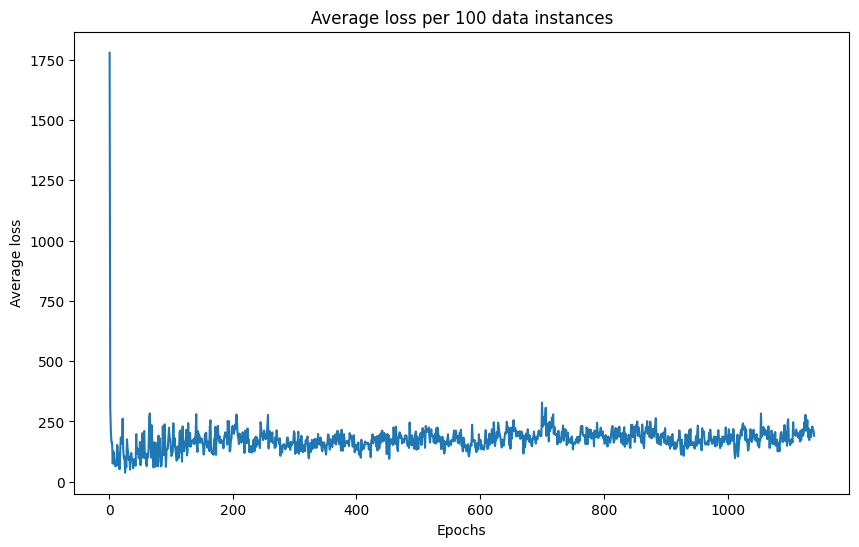

In [ ]:
batch_loss4=avg_loss(loss4)
plot(batch_loss4)

#PART D

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
X_train, X_test, Y_train, Y_test = train_test_split(flatten_X, encoded_Y,test_size = 0.2,random_state =4)

In [ ]:
mlp_model1 = MLPClassifier(hidden_layer_sizes=(100,50,50), activation='logistic', solver='adam', max_iter=1000, validation_fraction=0.1,random_state=4)
mlp_model1.fit(X_train,Y_train)


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50, 50),
              max_iter=1000, random_state=4)

In [ ]:
training_accuracy=mlp_model1.score(X_train, Y_train)
testing_accuracy=mlp_model1.score(X_test, Y_test)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)


Training dataset accuracy score:  0.9836842105263158
Testing dataset accuracy score:  0.9828130480533146


In [ ]:
with open('architecture2_sklearn.pkl','wb') as f:
    pickle.dump(mlp_model1,f)

In [ ]:
mlp_model2 = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', max_iter=1000)
mlp_model2.fit(X_train,Y_train)

MLPClassifier(activation='logistic', max_iter=1000)

In [ ]:
training_accuracy=mlp_model2.score(X_train, Y_train)
testing_accuracy=mlp_model2.score(X_test, Y_test)
print("Training dataset accuracy score: ",training_accuracy)
print("Testing dataset accuracy score: ",testing_accuracy)

Training dataset accuracy score:  0.9928070175438597
Testing dataset accuracy score:  0.9866713433882848


In [ ]:
with open('architecture1_sklearn.pkl','wb') as f:
    pickle.dump(mlp_model2,f)